Use GPyTorch
Use Spectral Mixture kernel

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [6]:
N=X.shape[0]
N_part=11300

In [7]:
X_part=X[:N_part]
Y_part=Y[:N_part]

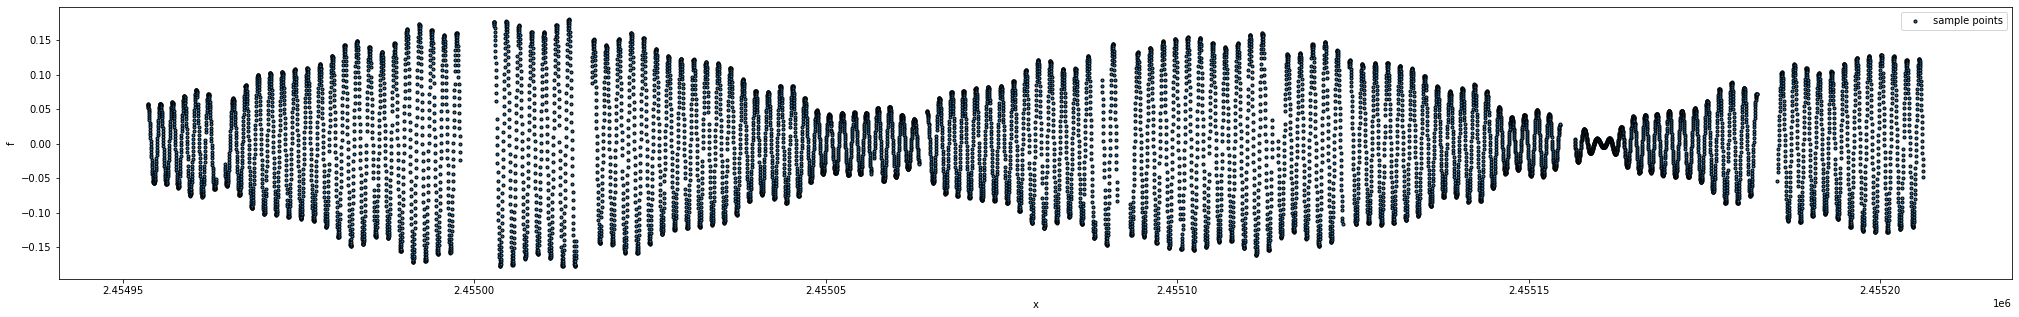

In [8]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [9]:
X_part=torch.tensor(X[:N_part])
Y_part=torch.tensor(Y[:N_part])

In [10]:
# Don't normalize here, as the data is already mean centered and we have included the RMSE
# numbers already in the paper.
# _, _, Y_part = experiment_util.normalize_mean(Y_part)

In [11]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [12]:
NUM_MIXTURES=25

In [13]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=NUM_MIXTURES)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

Move data and models to the GPU

In [14]:
if USE_CUDA:
    X_part = X_part.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [ ]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
final_params = all_params
# final_params = list(all_params - {model.covar_module.base_kernel.raw_period_length})
optimizer = torch.optim.Adam(final_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
#        model.covar_module.base_kernel.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mu_part_smooth = likelihood(model(X_part_smooth))

In [ ]:
with torch.no_grad():
    plotter.plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part_smooth.cpu().numpy(), mu_part_smooth.mean.cpu().numpy())

### RMSE

In [ ]:
experiment_util.calculate_error(Y_part, mu_part_smooth.mean.cpu())